# Introducción

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tenemos acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

# Objetivo

Crear un modelo que determine el valor de mercado. A la empresa le interesa:

-la calidad de la predicción;

-la velocidad de la predicción;

-el tiempo requerido para el entrenamiento

Para realizar esta tarea será necesario entrenar distintos modelos. Se debe empezar por un modelo de regresión lineal que funja como pruba de cordura. La métrica que se utilizará como base de comparación será la raiz del error cuadrático medio (RECM). Los modelos a comparar serán Bosque aleatorio y modelo basado en el descenso del gradiente.

Regresión Lineal.

Bosque aleatorio.

Modelo del descenso del gradiente con LightGBM

# Descripción de los datos

Características

* DateCrawled — fecha en la que se descargó el perfil de la base de datos

* VehicleType — tipo de carrocería del vehículo

* RegistrationYear — año de matriculación del vehículo

* Gearbox — tipo de caja de cambios

* Power — potencia (CV)

* Model — modelo del vehículo

* Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)

* RegistrationMonth — mes de matriculación del vehículo

* FuelType — tipo de combustible

* Brand — marca del vehículo

* NotRepaired — vehículo con o sin reparación

* DateCreated — fecha de creación del perfil

* NumberOfPictures — número de fotos del vehículo

* PostalCode — código postal del propietario del perfil (usuario)

* LastSeen — fecha de la última vez que el usuario estuvo activo

* Objetivo

* Price — precio (en euros)

# Preparación de datos

In [13]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import lightgbm as lgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [14]:
df= pd.read_csv('/datasets/car_data.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

El DataFrame contiene 354,369 registros con 16 columnas relacionadas con características de vehículos de segunda mano, incluyendo atributos técnicos (potencia, tipo de combustible, kilometraje) y temporales (fecha de registro y última actividad). Aunque es rico en datos, presenta valores nulos en columnas clave como "VehicleType", "FuelType" y "NotRepaired", lo que requiere limpieza antes del modelado. Este dataset es adecuado para predecir el precio de mercado, pero será fundamental manejar adecuadamente las características categóricas y numéricas, así como normalizar y codificar según el modelo utilizado. Su estructura sugiere potencial para análisis robustos, pero también desafíos en el procesamiento de datos.

In [16]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


# Análisis visual de los datos

En esta sección vamos a realizar un análisis a los datos a través de dos gráficas que son: gráfica de barras que nos mostraran los 10 autos más vendidos según el data set al igual de un gráfico de diagrama de caja y bigote identificando principalmente si hay valores atípicos.

## Gráfico de barras

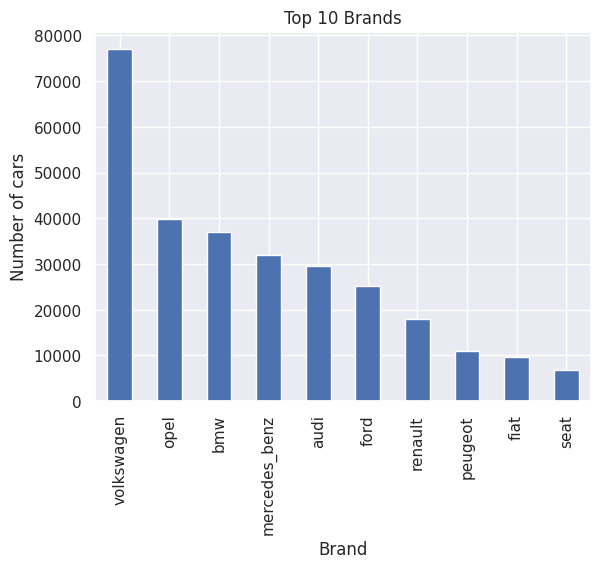

In [17]:
best_brands = df.groupby('Brand')['Brand'].count().sort_values(ascending=False).head(10)

best_brands.plot(kind="bar", x="Brand", 
                title="Top 10 Brands", ylabel='Number of cars',xlabel='Brand')
plt.show()

El gráfico de barras muestra que Volkswagen domina el mercado en este dataset, con un número significativamente mayor de coches registrados en comparación con otras marcas como Opel y BMW. Esto sugiere que Volkswagen tiene una fuerte presencia en el mercado de vehículos de segunda mano, lo que podría influir en el análisis de precios y estrategias de mercado en el proyecto.

## Gráfico de caja y bigote

<AxesSubplot:xlabel='RegistrationYear'>

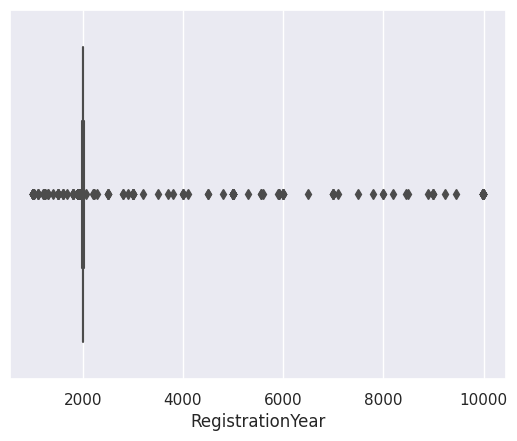

In [18]:
sns.boxplot(x=df['RegistrationYear'])

<AxesSubplot:xlabel='Power'>

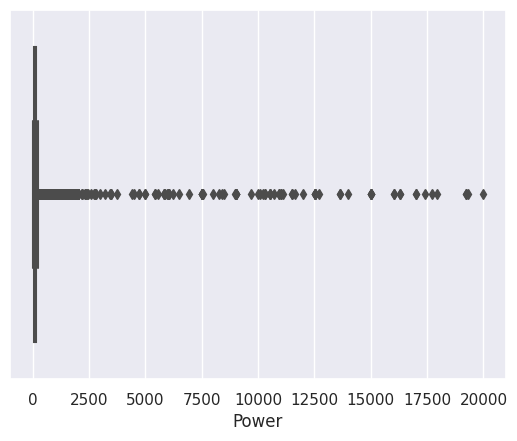

In [19]:
sns.boxplot(x=df['Power'])


Los diagramas de caja muestran una gran cantidad de valores atípicos tanto en los años de registro (RegistrationYear) como en la potencia (Power). En el primer caso, los años de registro incluyen valores irreales (muy superiores al año actual), lo que indica datos erróneos que deben ser filtrados. En el segundo caso, la potencia tiene valores extremadamente altos que no son representativos de la mayoría de los vehículos. Estos outliers pueden distorsionar el análisis y el modelo, por lo que es crucial aplicar estrategias de limpieza, como recortar rangos razonables o imputar valores.

# Eliminación de columnas innecesarias

En el dataset tenemos disponible bastante valores nulo y columnas que no aportan nada para determinar el precio final de un vehículo por lo cual procederemos a eliminarlos.

In [20]:
trash = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode']

df = df.drop(trash, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


# Tratamiento de valores nulos

Como los valores no son númericos se remplazará con el término 'unknown'.

In [21]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [22]:
df = df.fillna('unknown')
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


# Codificación

One-Hot Encoding transforma variables categóricas en columnas binarias (0 y 1) para que los modelos de machine learning puedan procesarlas. En este proyecto, se usaría para convertir columnas como VehicleType, FuelType o Gearbox en formato numérico utilizando herramientas como OneHotEncoder, el único incomeninete sería que va a crear demasiadas columnas por lo cual afectaría al rendimiento del model, por esta razón voy a sustiruit el valor categórico por la frecuencia, en otras palabras, vamos a procesar el modelo por el número de veces que se repite cada variable.

In [23]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for cat in cat_col:
    df[cat] = df.groupby(cat)[cat].transform('count')

df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,37490,1993,268251,0,29232,150000,0,216352,77013,71154
1,18300,16163,2011,268251,190,19705,125000,5,98720,29456,36054
2,9800,11996,2004,66285,163,561,125000,8,98720,677,71154
3,1500,79831,2001,268251,75,29232,150000,6,216352,77013,247161
4,3600,79831,2008,268251,69,2080,90000,7,98720,5500,247161


In [24]:
target = df['Price']
features = df.drop(['Price'], axis=1)
target.shape, features.shape

((354369,), (354369, 10))

# Escalado y estandarización de características.

Dado que cada columna tiene un rango diferente debido a las distintas frecuencias, esto podría generar confusión para el modelo durante el entrenamiento. Por esta razón, es importante estandarizar todas las características para evitar que algunas variables influyan más de lo necesario en el modelo y afecten la precisión de nuestras predicciones.

In [25]:
columns = features.columns
for col in features[columns]:
    minimo = features[col].min()
    maximo = features[col].max()
    print(f"{col}: minimo = {minimo}, maximo = {maximo}")

VehicleType: minimo = 3288, maximo = 91457
RegistrationYear: minimo = 1000, maximo = 9999
Gearbox: minimo = 19833, maximo = 268251
Power: minimo = 0, maximo = 20000
Model: minimo = 2, maximo = 29232
Mileage: minimo = 5000, maximo = 150000
RegistrationMonth: minimo = 0, maximo = 12
FuelType: minimo = 90, maximo = 216352
Brand: minimo = 225, maximo = 77013
NotRepaired: minimo = 36054, maximo = 247161


In [26]:
scaler = StandardScaler()

scaler.fit(features[columns])

features[columns] = scaler.transform(features[columns])

features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,-0.894770,-0.124512,0.563461,-0.579901,2.071540,0.574823,-1.533550,0.764998,1.662034,-1.373884
1,-1.667053,0.074983,0.563461,0.420888,1.050306,-0.084716,-0.191778,-0.913027,-0.200203,-1.778483
2,-1.817946,-0.002598,-1.638502,0.278671,-1.001809,-0.084716,0.613285,-0.913027,-1.327130,-1.373884
3,0.638460,-0.035848,0.563461,-0.184853,2.071540,0.574823,0.076576,0.764998,1.662034,0.654953
4,0.638460,0.041734,0.563461,-0.216457,-0.838982,-1.008070,0.344931,-0.913027,-1.138271,0.654953


# Datasets de entrenamiento y validación

Se procederá a dividir los datos con el uso de train_test_split en dos etapas de entrenamiento, validación y prueba, con el fin de que sean independientes entre sí, evitando la contaminación de datos.
Vamos a convertir los conjuntos de datos en matrices de NumPy mejora la eficiencia computacional, ya que la mayoría de bibliotecas de machine learning trabajan mejor con matrices Numpy que con DataFrames de pandas.

In [27]:

features_train, sub_features, target_train, sub_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    sub_features, sub_target, test_size=0.50, random_state=12345)

X_train = np.array(features_train)
X_valid = np.array(features_valid)
X_test = np.array(features_test)

Y_train = np.array(target_train)
Y_valid = np.array(target_valid)
Y_test = np.array(target_test)

X_train.shape, X_valid.shape, X_test.shape

((212621, 10), (70874, 10), (70874, 10))

In [28]:
features_train, sub_features, target_train, sub_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    sub_features, sub_target, test_size=0.50, random_state=12345)

X_train = np.array(features_train)
X_valid = np.array(features_valid)
X_test = np.array(features_test)

Y_train = np.array(target_train)
Y_valid = np.array(target_valid)
Y_test = np.array(target_test)

X_train.shape, X_valid.shape, X_test.shape


((212621, 10), (70874, 10), (70874, 10))

# Entrenamiento del modelo 

In [40]:
def evaluate_model(model,X_train, Y_train, X_valid, Y_valid):
    """
    Entrena un modelo, calcula los tiempos de entrenamiento y predicción, y devuelve el RECM, tiempo de entrenamiento y timepo de predicción.
    
    Args:
    -model: el modelo a entrenar y evaluar.
    -X_train, Y_train: datos de entrenamiento.
    -X_valid, Y_valid: datos de validación.
    
    Returns:
    -error: RECM del modelo.
    -train_time: tiempo de entrenamiento.
    -pred_time: time de predicción.
    """
    #Medir tiempo de entrenamiento
    start_train = time.time()
    model.fit(X_train, Y_train)
    end_train = time.time()
    train_time = end_train - start_train
    
    #Medir timepo de predicción
    start_pred = time.time()
    predictions = model.predict(X_valid)
    end_pred = time.time()
    pred_time = end_pred - start_pred
    
    #Calcular RECM
    error = mean_squared_error(Y_valid, predictions, squared=False)
    
    return error, train_time, pred_time
    

# Modelo 1: Linear Regression

In [41]:

model_lr = LinearRegression()
error_lr, train_time_lr, pred_time_lr = evaluate_model(model_lr, X_train, Y_train, X_valid, Y_valid)
print(f"Linear Regression - RECM: {error_lr:.2f}, Tiempo de entrenamiento: {train_time_lr:.2f}s, Tiempo de predicción: {pred_time_lr:.2f}s")

Linear Regression - RECM: 3811.60, Tiempo de entrenamiento: 0.02s, Tiempo de predicción: 0.01s


El modelo de Linear Regression se destaca por su rapidez, con un tiempo de entrenamiento de 0.02 segundos y un tiempo de predicción de 0.01 segundos, lo que lo hace extremadamente eficiente en términos computacionales. Sin embargo, su RECM de 3811.60 es considerablemente alto, indicando que el modelo tiene dificultades para capturar relaciones complejas en los datos. Esto lo convierte en una opción poco viable para el problema en cuestión, ya que la precisión requerida por el negocio no se alcanza, a pesar de su rapidez.

# Modelo 2: Random Forest Regressor

In [45]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=10)
error_rf, train_time_rf, pred_time_rf = evaluate_model(model_rf, X_train, Y_train, X_valid, Y_valid)
print(f"Random Forest - RECM: {error_rf:.2f}, Tiempo de entrenamiento: {train_time_rf:.2f}s, Tiempo de predicción: {pred_time_rf:.2f}s")

Random Forest - RECM: 1978.77, Tiempo de entrenamiento: 23.23s, Tiempo de predicción: 0.44s


El modelo Random Forest alcanzó un RECM de 1978.77, mostrando una mejora significativa en comparación con la regresión lineal. Sin embargo, el tiempo de entrenamiento fue considerablemente alto, con 23.23 segundos, mientras que el tiempo de predicción fue más razonable, con 0.44 segundos. Esto indica que, aunque el modelo ofrece una mejor precisión, su tiempo de entrenamiento extenso podría ser un inconveniente en escenarios donde se requiera actualizar el modelo frecuentemente. En general, su desempeño es aceptable, pero no el más eficiente considerando los requisitos del negocio.

# Modelo 3: LightGBM

In [47]:
model_lgbm = lgb.LGBMRegressor(metric='rmse')
error_lgbm, train_time_lgbm, pred_time_lgbm = evaluate_model(model_lgbm, X_train, Y_train, X_valid, Y_valid)
print(f"LightGBM - RECM: {error_lgbm:.2f}, Tiempo de entrenamiento: {train_time_lgbm:.2f}s, Tiempo de predicción: {pred_time_lgbm:.2f}s")


LightGBM - RECM: 1835.64, Tiempo de entrenamiento: 2.83s, Tiempo de predicción: 0.39s


El modelo LightGBM obtuvo un RECM de 1835.64, destacándose como uno de los modelos más precisos probados. Además, su tiempo de entrenamiento fue de 2.83 segundos y el tiempo de predicción de 0.39 segundos, lo que demuestra una excelente eficiencia tanto en rapidez como en precisión. Estas características hacen que LightGBM sea una opción muy adecuada para el problema, especialmente en contextos donde se requiere un balance entre un tiempo de respuesta rápido y un bajo margen de error en las predicciones.

# Modelo 4: CatBoost

In [48]:
model_cb = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=10, loss_function='RMSE', verbose=0)
error_cb, train_time_cb, pred_time_cb = evaluate_model(model_cb, X_train, Y_train, X_valid, Y_valid)
print(f"CatBoost - RECM: {error_cb:.2f}, Tiempo de entrenamiento: {train_time_cb:.2f}s, Tiempo de predicción: {pred_time_cb:.2f}s")

CatBoost - RECM: 1776.89, Tiempo de entrenamiento: 10.28s, Tiempo de predicción: 0.03s


El modelo CatBoost obtuvo el mejor RECM de 1776.89, destacándose como el modelo más preciso entre los evaluados. Sin embargo, su tiempo de entrenamiento fue de 10.28 segundos, considerablemente más alto que el de LightGBM, mientras que el tiempo de predicción fue extremadamente rápido, con solo 0.03 segundos. Este rendimiento lo convierte en una excelente opción si se prioriza la precisión sobre el tiempo de entrenamiento. Aunque su tiempo de entrenamiento es mayor, sigue siendo manejable en comparación con otros modelos menos precisos.

## Análisis del modelo

Se implementaron y evaluaron cuatro modelos, considerando tanto su precisión (RECM) como sus tiempos de entrenamiento y predicción. Las conclusiones obtenidas son las siguientes:

- Linear Regression: Fue el modelo más rápido en términos de tiempo de entrenamiento y predicción, pero su RECM más alto (3811.60) lo posiciona como el menos preciso y el menos adecuado para este problema, ya que no captura bien las relaciones complejas en los datos.

- Random Forest Regressor: Aunque logró un RECM moderado de 1978.77, ajustar los hiperparámetros consumió mucho tiempo (23.23 segundos de entrenamiento). Además, su tiempo de predicción de 0.44 segundos lo hace menos eficiente en comparación con otros modelos. No es ideal para este caso debido a su alto costo computacional y precisión limitada.

- LightGBM: Ofreció un excelente balance entre precisión y eficiencia, con un RECM de 1835.64, un tiempo de entrenamiento de 2.83 segundos y un tiempo de predicción de 0.39 segundos. Este modelo es una opción destacada para tareas que requieran rapidez y buen desempeño sin comprometer mucho tiempo en entrenamiento.

- CatBoost: Destacó por ser el modelo más preciso, con un RECM de 1776.89. Aunque su tiempo de entrenamiento fue mayor (10.28 segundos), su tiempo de predicción de 0.03 segundos es el más rápido entre todos los modelos. Esto lo convierte en la mejor opción si la prioridad es la precisión sobre la rapidez del entrenamiento.

# Conclusión

En este proyecto se evaluaron cuatro modelos de machine learning para predecir el precio de vehículos de segunda mano, considerando precisión, tiempos de entrenamiento y predicción. El mejor modelo fue CatBoost, con el RECM más bajo (1776.89) y un tiempo de predicción extremadamente rápido (0.03 segundos), lo que lo hace ideal para tareas donde la precisión es la prioridad. Sin embargo, LightGBM también destacó por su balance entre precisión (RECM de 1835.64) y rapidez de entrenamiento (2.83 segundos), posicionándose como una excelente opción en escenarios donde el tiempo de entrenamiento es crucial. A pesar de los resultados obtenidos, se recomienda mejorar la calidad del dataset para lograr modelos aún más robustos y precisos.